From connectivity to graph network (Communities)

In [4]:
from IPython.display import Image
# from gtheory import config as cf
from glob import glob
# from gtheory.utils.misc import sort_path
import numpy as np
# pt = cf.root_path ()

Node to Node interaction

In [2]:
sbj1_path = sort_path ( glob ( f"{pt ['dir_root']}/*/*/connectivity_result.npz" ) ) [0]
arr = np.load(sbj1_path)
con=arr['con_arr'] # (epochs, nwindows, spectral_method, nchan, nchan, fbands)
ch_names=arr['ch_name'].tolist()

In [3]:
# Extract only delta band which have index 0
epoch_idx=0
spec_method_idx=0
fband_idx=0
arr_temporal=con[epoch_idx,:,spec_method_idx,:,:,fband_idx]
print(arr_temporal.shape)

# For visualization, we minimise the number of node to node connection
arr_temporal = np.where(arr_temporal < 0.8, 0, arr_temporal)

(4, 30, 30)


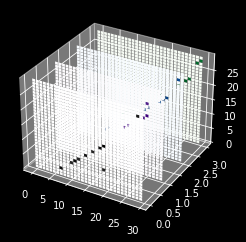

In [4]:
# Quick glance the about the arr_temporal shape
from gtheory.viz import viz_isometric_heatmap
data = arr_temporal
N = 30
viz_isometric_heatmap (data, N,background_style='dark_background' )

## Let visualise the connectivity accross slices

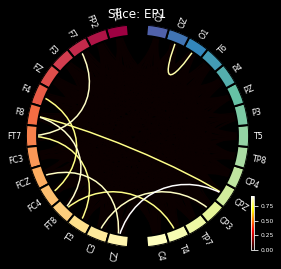

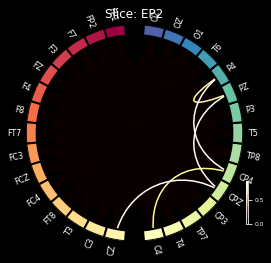

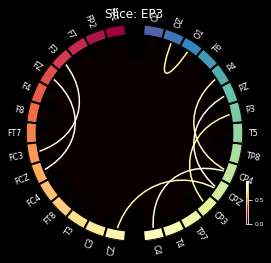

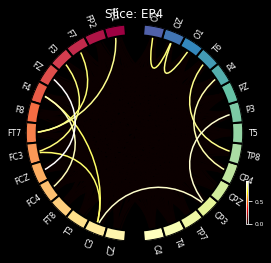

In [5]:
from gtheory.viz import viz_connectivity_circle
slice_name=[f'Slice {idx}' for idx in range(data.shape [0] )]
viz_connectivity_circle(arr_temporal,ch_names,['EP1', 'EP2', 'EP3', 'EP4'])

# leidenalg and igraph

Let see how to plot graph, and community assignment using igraph and leidenalg
igraph

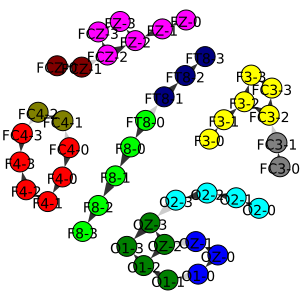

In [6]:
from gtheory.grapht import gt_leidenalg
from gtheory.utils import between_list_diff_index
from gtheory.utils.nparray import slice_array_with_list
import igraph as ig
ch_retain=['F3', 'FZ', 'F4', 'F8', 'FC3', 'FCZ', 'FC4', 'FT8', 'O1', 'OZ', 'O2']
retain_idx=between_list_diff_index (ch_names, ch_retain, output='retain_index')
arr_temporal=slice_array_with_list(arr_temporal,retain_idx.tolist())
ch_names=ch_retain

nslice=arr_temporal.shape[0]
slice_name=[f'Slice {idx}' for idx in range(nslice)]
gtl = gt_leidenalg ( arr_temporal, ch_names,slice_name=slice_name)
gtl.time_slices_to_layers ()
gtl.create_partitions ()

ig.plot ( gtl.partition_all, bbox=(0, 0, 300, 300),
                  vertex_label=[f'{v ["id"]}-{v ["slice"]}' for v in gtl.G.vs] )


Manually label


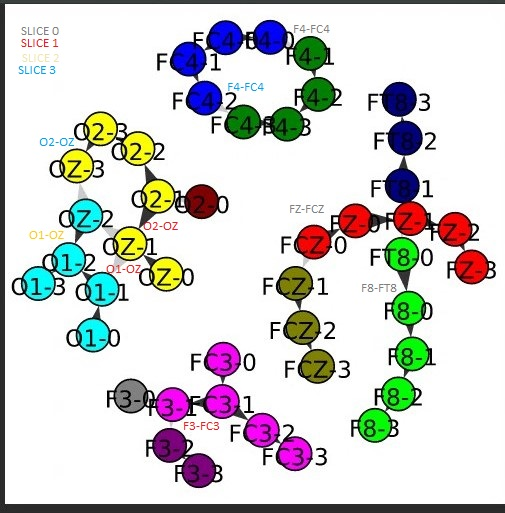

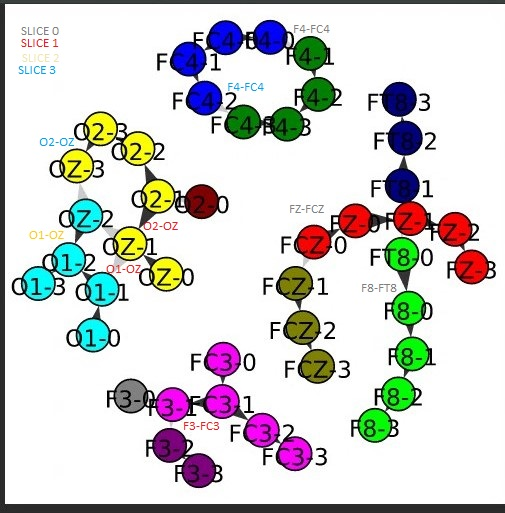

In [7]:
from IPython.display import Image
PATH = "../image/igraph_community.jpg"
Image(filename = PATH , width=1, height=1)

# Slice plot
TENETO received input of type array with construct (N,N,temporal_slice)
Since teneto received arr of [N,N, slice), convert the arr_temporal which originally of shape [slice,N,N] to [N,N,slice] using transponse

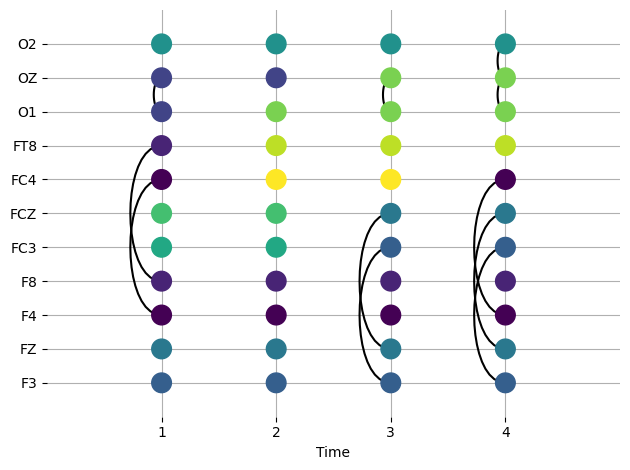

In [8]:
# https://teneto.readthedocs.io/en/latest/api/teneto.plot.slice_plot.html#teneto.plot.slice_plot

import teneto
import matplotlib.pyplot as plt
plt.style.use('mpl20')

communities=gtl.arr_to_membership()
communities=communities.values
g_arr=arr_temporal.T
tnet = teneto.TemporalNetwork(from_array=g_arr,nodelabels=ch_names)
tnet.plot('slice_plot', **{'communities': communities},nodesize=200)
plt.tight_layout()
plt.show()

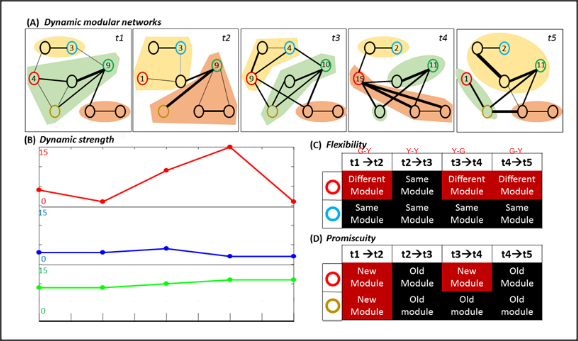

Dynamics of Flexibility:

the time-dependent flexibility of a region was defined as the probability that a brain region changed its allegiance to putative functional modules between any two consecutive time windows, and the time-dependent flexibility of a person was defined as the average regional flexibility over all brain areas included in the network.ntuitively, flexibility can be thought of as a statistic to quantify the amount of reconfiguration in functional connectivity patterns that a brain region displays over time.

/tmp/ipykernel_21063/1006757014.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['index']=df2['index']+1.5


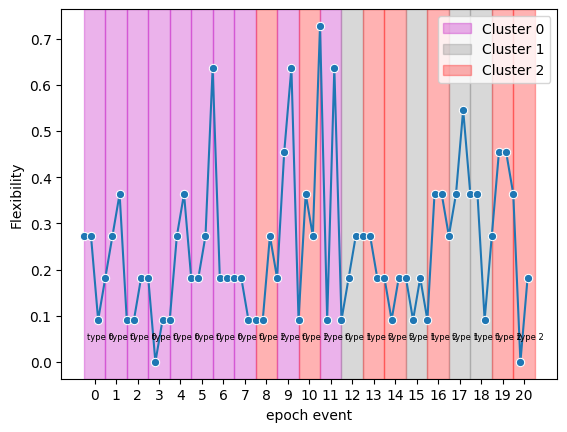

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# from matplotlib.lines import Line2D
# {0:'m',1:'gray',2:'r'}
legend_elements = [Patch(facecolor='m', edgecolor='m',label='Cluster 0',alpha=0.3),
                       Patch(facecolor='gray', edgecolor='gray',label='Cluster 1',alpha=0.3),
                       Patch(facecolor='r', edgecolor='r',label='Cluster 2',alpha=0.3)]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')
df=pd.read_feather('to_plot.feather')
df.reset_index(inplace=True)
df = df.head(63)
 # df=df.iloc[24:63]
df2 = df.iloc[::3, :]
df.rename(columns={'group': 'type'}, inplace=True)
g = sns.lineplot(data=df, x="index", y="nval",marker='o')
df2['index']=df2['index']+1.5
nxtick=df2['index'].values.tolist()
g.set_xticks(nxtick) # <--- set the ticks first
nxlabel=df2['epoch_seq'].values.tolist()
g.set_xticklabels(nxlabel)
overlay = {0:'m',1:'gray',2:'r'}

for i in np.arange(0,len(df),3):
    tmp = df.iloc[i:i+3, :]
    v = overlay.get(tmp.type.unique()[0])
    g.axvspan(min(tmp.index), max(tmp.index)+1, color=v, alpha=0.3)
    g.text(((min(tmp.index)+max(tmp.index)+1) / 2)-1,
               0.05,'type {}'.format(tmp.type.unique()[0]), fontsize=6)

g.set(xlabel='epoch event', ylabel='Flexibility')
g.legend(handles=legend_elements, loc='best')
plt.show()

# Cognitive system recruitment

To determine whether cognitive systems are transiently or consistently recruited during
task execution
- Modular allegiance matrix
- Consensus partition
- Integration

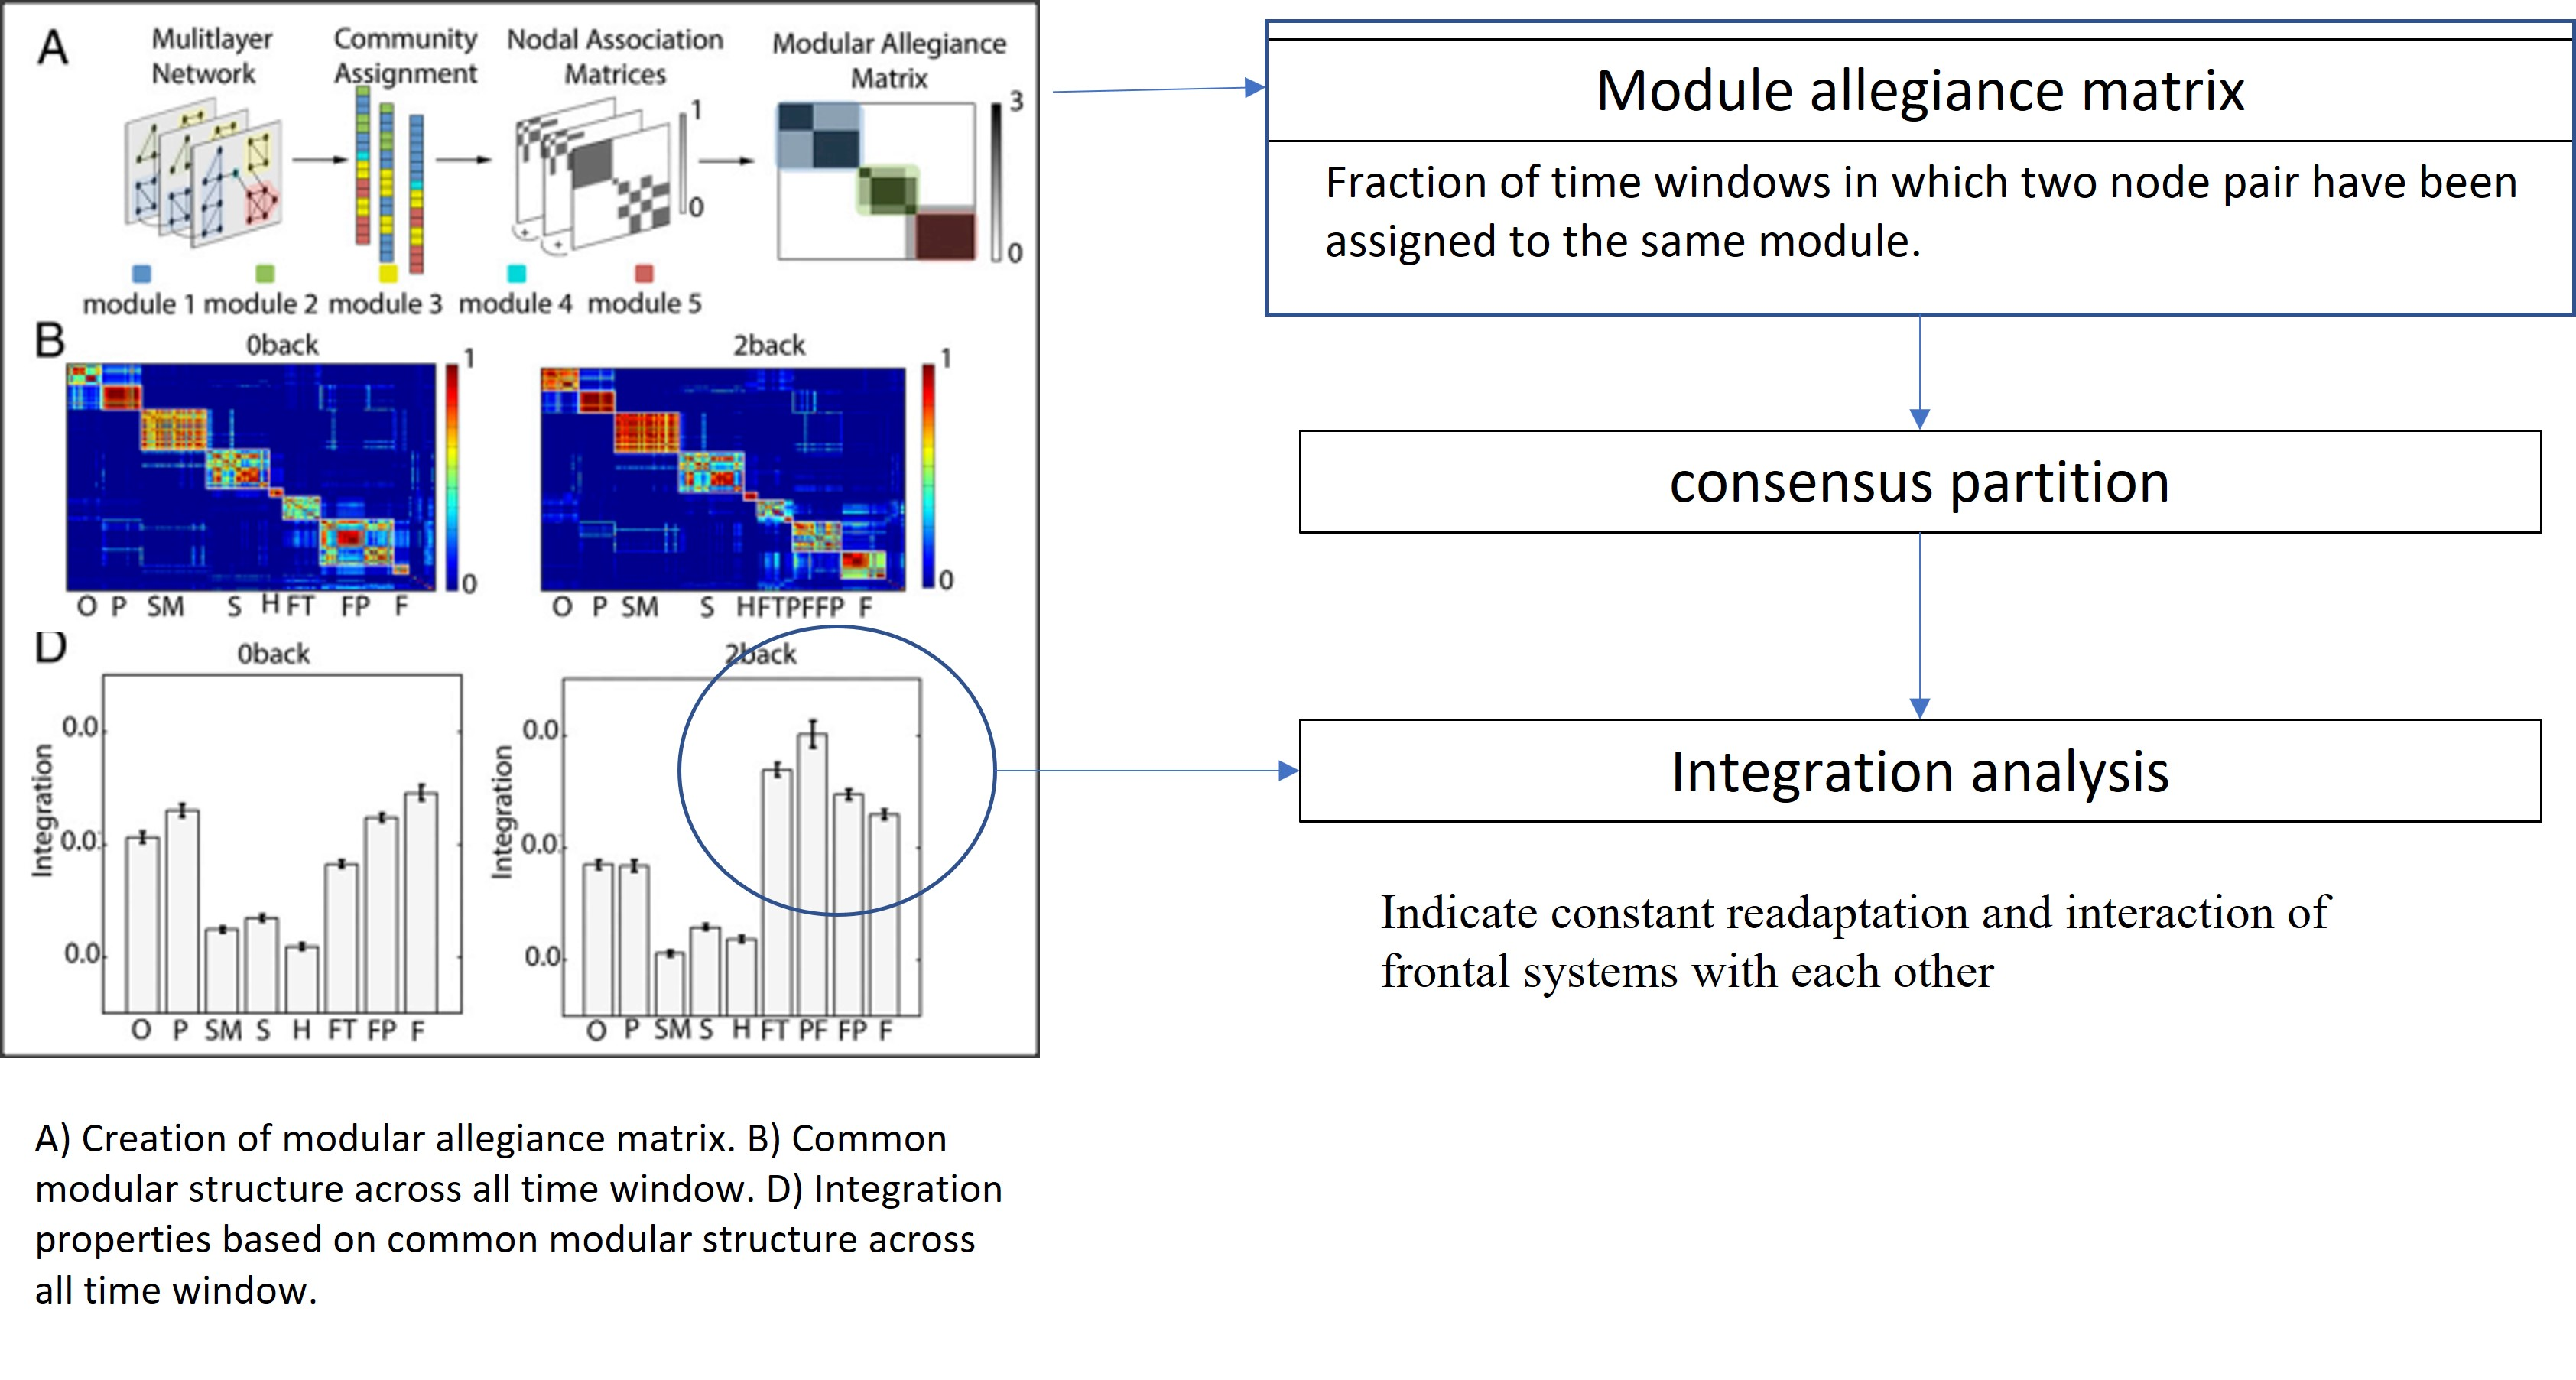

In [10]:
Image(filename = "../image/cognitive_system_recruitment.jpg" , width=1, height=1)

#  Modular allegiance matrix

Compute the contingency matrix N for each window: the element $N_{ij}$ is equal to 1 if nodes i and j are in the same
module and is equal to zero otherwise. We sum all contingency matrices for each condition to obtain the modular
allegiance matrix T, whose elements $T_{ij}$ indicate the fraction of time windows in which nodes i and j have been
assigned to the same module

\begin{aligned} & \text {ma}\\ &\begin{array}{cccc} \hline A & 0 \\ B & 4\\ C & 1 \\ D & 1 \\ E & 1 \\ \hline
\end{array} \end{aligned}

Output

\begin{aligned} & \text {ma}\\ &\begin{array}{cccc} \hline -&A & B & C & D & E\\ A & 1 & 0 & 0 & 0 & 0 \\ B & 0 & 1 & 0
& 0 & 0\\ C & 0 & 0 & 1& 1 & 1 \\ D & 0 & 0 & 1& 1& 1 \\ E & 0 & 0 & 1 & 1 & 1 \\ \hline \end{array} \end{aligned}

In [11]:
import numpy as np

arr = [ [ 0 , 0 , 0 , 0 , 0 ] ,
        [ 0 , 4 , 1 , 1 , 1 ] ,
        [ 0 , 1 , 1 , 2 , 2 ] ,
        [ 0 , 3 , 2 , 2 , 2 ] ]
a = np.array ( arr )

MA = (a.T == a.T [ : , None ]).sum ( 2 )
print ( MA )


[[4 1 1 1 1]
 [1 4 2 1 1]
 [1 2 4 3 3]
 [1 1 3 4 4]
 [1 1 3 4 4]]


# Consensus partition

Apply a community detection algorithm to T to obtain a “consensus partition” (25), which represents the common modular
structure across all time windows

In [12]:
from gtheory.grapht import consensus_iterative

S2 , Q2 , new_MA , qpc = consensus_iterative (MA) ;
com_s2 = S2 [ 0 , : ]
print ( f'Community Assignment: {com_s2}')

0
1
2
3
4
0
1
2
3
4
Community Assignment: [1 2 3 4 4]


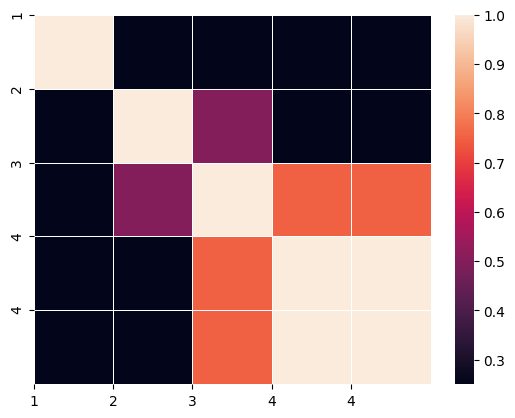

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
C=4 #Nslice
P = (1/C)*MA
g = sns.heatmap(P, linewidth=0.5)
g.set_xticks(range(5)) # <--- set the ticks first
g.set_xticklabels(com_s2)
g.set_yticks(range(5)) # <--- set the ticks first
g.set_yticklabels(com_s2)
plt.show()

# Issue: Why we have value range {0,4}, but in the paper, scaled to {0,1}?
# Most probably they divide nchanges/ sum of possible changes

# END HERE (KIV Integration analysis)


# Flexibility TENETO

# Other notes


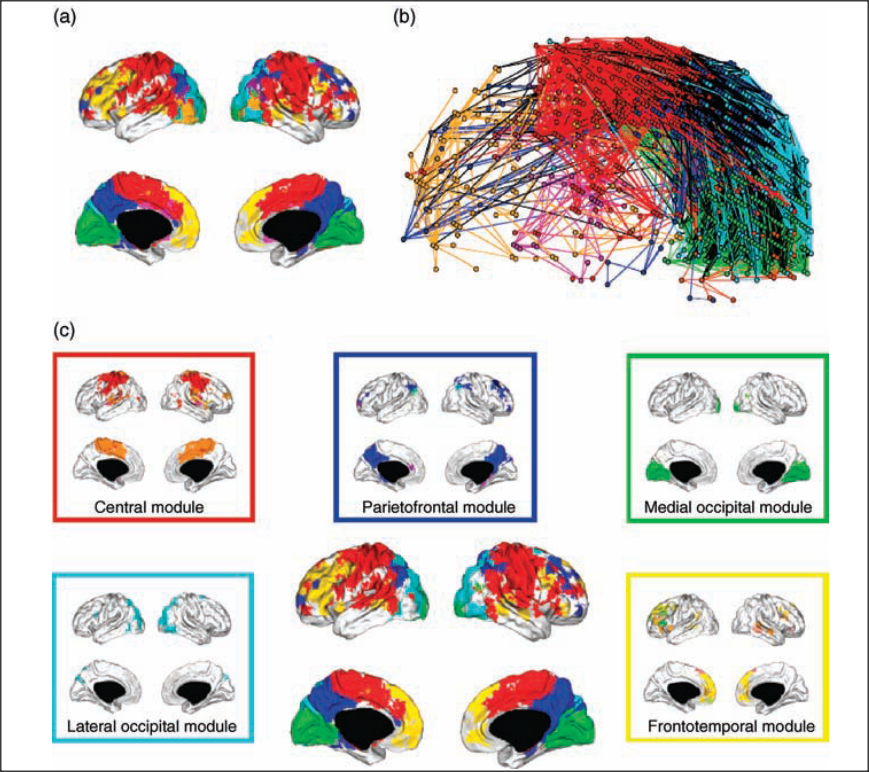

Hierarchical modularity ofa human brain functional network. (a) Cortical surface mapping ofthe community structure ofthe network at the highest level ofmodularity; (b) anatomical representation ofthe connectivity between nodes in color-coded modules. The brain is viewed from the left side with the frontal cortex on the left ofthe panel and occipital cortex on the right. Intramodular
edges are colored differently for each module; intermodular edges are drawn in black; (c) submodular decomposition ofthe five largest modules (shown centrally) illustrates, for example, that the medial occipital module has no major submodules whereas the frontotemporal module has many submodules. Reprinted with permission from Ref. [79].



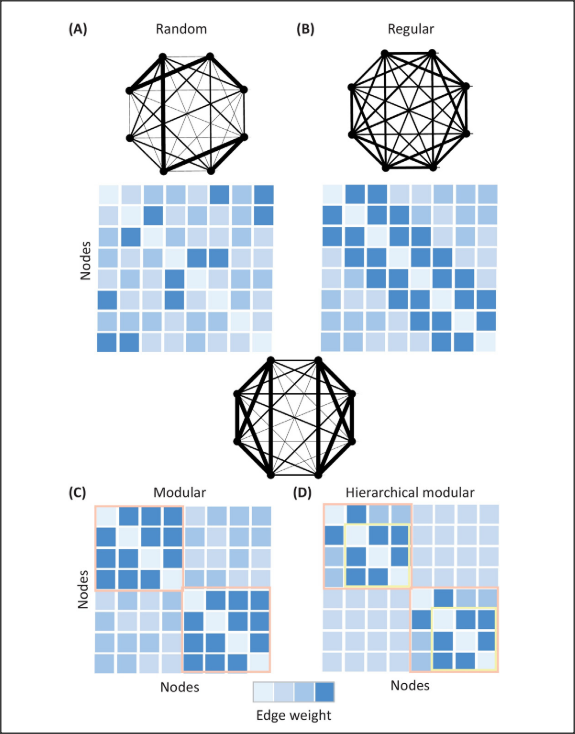

Neural Systems Can Display Different Connectivity Patterns. (A) In a random graph, each node has an equal probability of connecting to any other node. (B) In a regular graph, every node has an equal degree, k; in a regular ring lattice, every node has the same number of edges, and those edges link each node to its k nearest neighbors on the ring. (C) In a modular graph, groups of nodes are densely



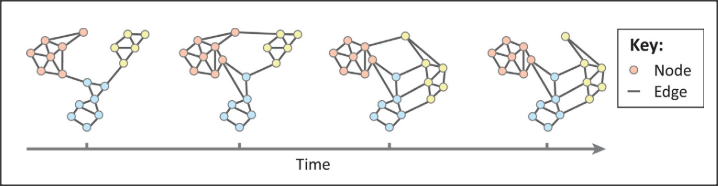

Reconfiguration of Network Modules. A schematic illustrating how patterns of connectivity can change over time as someone learns. For example, network modules can separate (as the pink and yellow modules do) or coalesce (as the blue and yellow modules do). Reconfiguration can also occur at the level of single nodes, which might initially be part of one module, and then change to be part of another module (as does the node at the top of this temporal graph, which starts by being affiliated with the pink module and ends being affiliated with the yellow module).


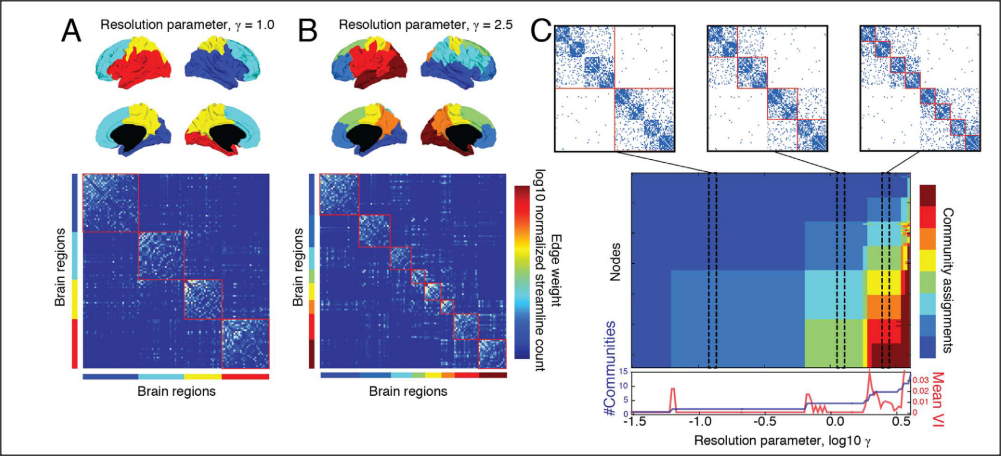

Schematic figure illustrating multi-scale community detection. Networks exhibit community structure over a range of different topological scales. In panels (A) and (B) we show communities detected in a structural connectivity network at two different topological scales (the colors in the surface plots indicate the community to which each region is assigned). We investigate these scales by tuning the resolution parameter in modularity maximization (a common community detection approach) to γ = 1 and γ =2.5. In panel (C) we illustrate the multi-resolution approach for “sweeping” through a range of resolution parameters to detect communities at different scales, this time using a synthetic network constructed to have hierarchical community structure (hierarchical levels that divide the network into 2, 4, and 8 communities). To identify topological scales of interest (ranges of γ), we calculated the mean pairwise variation of information (VI) of all partitions detected at each value of γ. Low values of VI indicate that on average the detected partitions were similar to one another. The metric VI achieves local minima at scales that uncover the planted hierarchical communities; at values of γ where none of the planted hierarchical communities are detected, VI takes on non-zero values, indicating lack of consensus across detected partitions and highlighting values of γ at which community structure is not present.



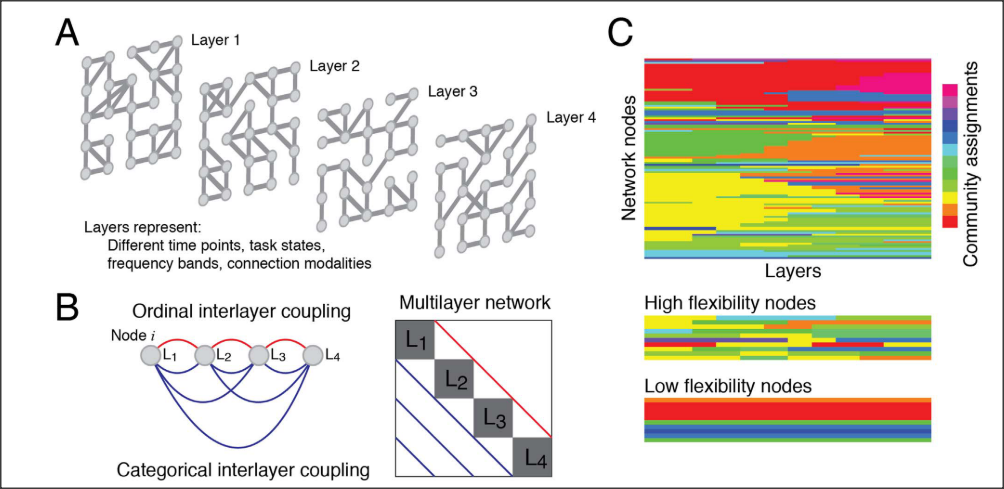

Schematic figure illustrating multi-layer network construction and community detection. Individual networks can be combined in a meaningful way to form a multi-layer network. In panel (A) we show four example networks, each of which contains the same 25 nodes but arranged in different configurations. The links in these networks could represent fluctuating functional connections over time (e.g., within a single scan or over development), connections estimated during different tasks, different frequency bands, or different connection modalities (e.g., structural connections weighted by streamline count or fractional anisotropy or functional connections measured as correlations or coherence). (B)To combine individual layers, links are added from node i to itself across layers. These links can be added ordinally, linking a node to itself in adjacent layers, or categorically, linking a node to itself across all layers. The result is a multi-layer network. (C) Multi-layer networks can be analyzed using many now-standard measures in network science, including—but not limited to—community detection algorithms. The resulting estimate of communities allows us to track the formation and dissolution of communities across layers and report properties of individual nodes—e.g., their flexiblity, which measures how frequently a node changes its community assignment.



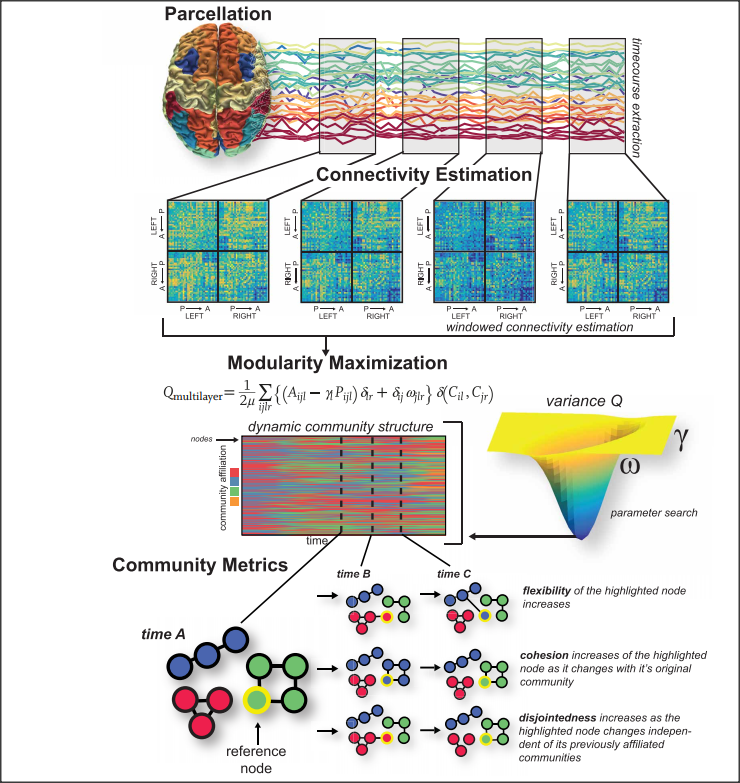

Building temporal brain graphs and characterizing their dynamic community structure. Here we illustrate methodological steps to build a temporal brain graph and to estimate its dynamic community structure. First, we define nodes, shown here as a whole-brain parcellation. Next, in each time window, we define edges, shown here as statistical similarities in regional time series. We build a multilayer graph from the ordered set of graphs across all time windows, and we link graphs in neighboring layers by identity links (edges between node i in layer t and itself in layer t − 1 and t + 1 ). After constructing the multilayer brain graph, we can apply a community detection technique such as the maximization of a multilayer modularity quality function. This process produces a time-dependent partition of nodes into communities or modules. Because multilayer modularity maximization contains tunable parameters, we might also wish to search the 2-D parameter space to find a parameter pair that results in a stable partition (for example, here reflected by a low variance of Q multilayer across multiple iterations of the maximization algorithm). Finally, the dynamic community structure can be quantitatively characterized with graph statistics (e.g., flexibility, cohesion, disjointedness, and promiscuity).

Evolving network configuration

Fig. 2. Evolving network organization. (A) To determine whether cognitive
systems are transiently or consistently recruited during task execution, we
construct a modular allegiance matrix T by computing the contingency
matrix N for each window: the element Nij is equal to 1 if nodes i and j are in
the same module and is equal to zero otherwise. We sum all contingency
matrices for each condition to obtain the modular allegiance matrix T,
whose elements Tij indicate the fraction of time windows in which nodes
i and j have been assigned to the same module. We then apply a community
detection algorithm to T to obtain a “consensus partition” (25), which represents the common modular structure across all time windows. (B) The
modular allegiance matrices for the 0-back condition (Left) and 2-back
condition (Right). The letter beneath the block diagonal elements indicates
the network module identified in the consensus partition: F, frontal; FP,
frontal-parietal; FT, frontotemporal; H, hippocampal; O, occipital; P, parietal;
PF, right prefrontal; S, subcortical; SM, somatomotor. (C) A mapping of the
frontal modules obtained in B to their brain coordinates for the 0-back (Left)
and 2-back condition (Right); labels are as in C. (D) Frontal systems show high
integration during 2-back, whereas during 0-back occipital and parietal
systems show an equally strong interaction. Error bars indicated SEs of mean
over partitions belonging to either to 0-back or 2-back conditions.


1) modular allegiance matrix: Teneto: allegiance(community)
2) consensus partition : consensus_iterative(C)
3) Integration: integration(MA,systemByNode) | integration(temporalcommunities, staticcommunities)

# Community measures

In [14]:
# Allegiance

In [15]:
from teneto.communitymeasures import allegiance
a_allegiance = allegiance(community)

NameError: name 'community' is not defined

# flexibility

In [ ]:
community=[] # previously, we calculate the community from leidenalg
from teneto.communitymeasures import flexibility
a_flex = flexibility(community)

In [ ]:
from teneto.communitymeasures import promiscuity
a_promiscuity = promiscuity(community)

# Integration community

In [ ]:
# arr_allegiance=np.array([[np.nan,1.00000,1.00000,0.50000,0.00000,0.00000],
#        [1.00000,np.nan,1.00000,0.50000,0.00000,0.00000],
#        [1.00000,1.00000,np.nan,0.50000,0.00000,0.00000],
#        [0.50000,0.50000,0.50000,np.nan,0.50000,0.50000],
#        [0.00000,0.00000,0.00000,0.50000,np.nan,1.00000],
#        [0.00000,0.00000,0.00000,0.50000,1.00000,np.nan]])

arr_allegiance=np.array([[0,1.00000,1.00000,0.50000,0.00000,0.00000],
       [1.00000,0,1.00000,0.50000,0.00000,0.00000],
       [1.00000,1.00000,0,0.50000,0.00000,0.00000],
       [0.50000,0.50000,0.50000,0,0.50000,0.50000],
       [0.00000,0.00000,0.00000,0.50000,0,1.00000],
       [0.00000,0.00000,0.00000,0.50000,1.00000,0]])
label_allegiance=['a','b','c','d','d','e','f']

In [ ]:
G_allegiance = ig.Graph.Weighted_Adjacency ( arr_allegiance.tolist () )
G_allegiance.vs ['id'] = label_allegiance

In [ ]:
partition_allegiance = la.find_partition(G_allegiance, la.CPMVertexPartition,resolution_parameter = 0.05)

In [ ]:
ig.plot(partition_allegiance,vertex_label=G_allegiance.vs['id'],
        bbox=(0, 0, 300, 300))

# vertex_label = [f'{v["id"]}-{v["slice"]}' for v in G.vs

In [ ]:
import numpy as np
import teneto
from teneto.communitymeasures import allegiance


np.random.seed(10)
# Two graphlets templates with definite community structure
a = np.array([[1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [
                 0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]])
b = np.array([[1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0], [
                 1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1]])
# Make into 4 time points
G = np.stack([a, a, b, b]).transpose([1, 2, 0])

# returns node,time array of community assignments
community = teneto.communitydetection.temporal_louvain(G, intersliceweight=0.1, n_iter=1)

AR_P = allegiance(community)


In [ ]:
arr_g=np.tril(AR_P,-1)
lower_idx=np.tril_indices(arr_g)

In [ ]:
arr_g=np.tril(np.random.rand(10,10),-1)

In [ ]:
lower_idx=np.tril_indices_from(arr_g)
# lower_idx=np.tril(arr_g)
A_1=list(arr_g[lower_idx])

In [ ]:
X = np.zeros((10,10))
X[np.tril_indices_from(X)] = A_1
# AOO=np.array([[0.0,0.0,0.0],
# [0.11089102200884637,0.0,0.0],
# [0.154053775043979,0.11389454176398306,0.0]])
#
# A00=AOO.T